# Pytorch-自己训练的水果图像分类模型可解释性分析

对自己训练得到的30类水果图像分类模型进行可解释性分析。可视化指定预测类别的shap值热力图。

同济子豪兄 https://space.bilibili.com/1900783

代码运行云GPU平台：https://featurize.cn/?s=d7ce99f842414bfcaea5662a97581bd1

2022-10-24

## 预备知识

图像分类工作流：数据集、训练、预测、评估、可解释性分析、部署

视频教程：https://www.bilibili.com/video/BV1Jd4y1T7rw

代码教程：https://github.com/TommyZihao/Train_Custom_Dataset

## 导入工具包

In [16]:
import json
import numpy as np
from PIL import Image
import torch
import torch.nn as nn
import torchvision
from torchvision import transforms
import shap

# 有 GPU 就用 GPU，没有就用 CPU
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print('device', device)

device cuda:0


## 载入30类水果图像分类模型

In [17]:
model = torch.load(r'E:\MV-Code-202018010103-Lucy\main\Train_Custom_Dataset\图像分类\3-【Pytorch】迁移学习训练自己的图像分类模型\checkpoint\best-1.000.pth')
model = model.eval().to(device)

## 载入水果分类数据集的类别

In [18]:
idx_to_labels = np.load(r'E:\MV-Code-202018010103-Lucy\main\Train_Custom_Dataset\图像分类\3-【Pytorch】迁移学习训练自己的图像分类模型\idx_to_labels.npy', allow_pickle=True).item()

In [19]:
idx_to_labels

{0: 'parasitized', 1: 'uninfected'}

In [20]:
class_names = list(idx_to_labels.values())

In [21]:
class_names

['parasitized', 'uninfected']

## 载入一张测试图像，整理维度

In [71]:
img_path = r"C:\Users\61640\Desktop\Image_20240410210531.png"

In [72]:
img_pil = Image.open(img_path)
X = torch.Tensor(np.array(img_pil)).unsqueeze(0)

In [73]:
X.shape

torch.Size([1, 1264, 1368, 4])

In [74]:
img_path = r"C:\Users\61640\Desktop\Image_20240410210531.png"

# Open the image using Pillow
img_pil = Image.open(img_path)

# Convert the image to RGB (removing the alpha channel)
img_rgb = img_pil.convert('RGB')

# Convert the RGB image to a PyTorch tensor
X = torch.Tensor(np.array(img_rgb)).unsqueeze(0)

# Check the shape of the tensor
print(X.shape)

torch.Size([1, 1264, 1368, 3])


## 预处理

In [75]:
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]

def nhwc_to_nchw(x: torch.Tensor) -> torch.Tensor:
    if x.dim() == 4:
        x = x if x.shape[1] == 3 else x.permute(0, 3, 1, 2)
    elif x.dim() == 3:
        x = x if x.shape[0] == 3 else x.permute(2, 0, 1)
    return x

def nchw_to_nhwc(x: torch.Tensor) -> torch.Tensor:
    if x.dim() == 4:
        x = x if x.shape[3] == 3 else x.permute(0, 2, 3, 1)
    elif x.dim() == 3:
        x = x if x.shape[2] == 3 else x.permute(1, 2, 0)
    return x 
        

transform= [
    transforms.Lambda(nhwc_to_nchw),
    transforms.Resize(224),
    transforms.Lambda(lambda x: x*(1/255)),
    transforms.Normalize(mean=mean, std=std),
    transforms.Lambda(nchw_to_nhwc),
]

inv_transform= [
    transforms.Lambda(nhwc_to_nchw),
    transforms.Normalize(
        mean = (-1 * np.array(mean) / np.array(std)).tolist(),
        std = (1 / np.array(std)).tolist()
    ),
    transforms.Lambda(nchw_to_nhwc),
]

transform = torchvision.transforms.Compose(transform)
inv_transform = torchvision.transforms.Compose(inv_transform)

## 构建模型预测函数

In [76]:
def predict(img: np.ndarray) -> torch.Tensor:
    img = nhwc_to_nchw(torch.Tensor(img)).to(device)
    output = model(img)
    return output

In [77]:
def predict(img):
    img = nhwc_to_nchw(torch.Tensor(img)).to(device)
    output = model(img)
    return output

## 测试整个工作流正常

In [78]:
Xtr = transform(X)
out = predict(Xtr[0:1])

In [79]:
out.shape

torch.Size([1, 2])

In [80]:
classes = torch.argmax(out, axis=1).detach().cpu().numpy()
print(f'Classes: {classes}: {np.array(class_names)[classes]}')

Classes: [0]: ['parasitized']


## 设置shap可解释性分析算法

In [81]:
# 构造输入图像
input_img = Xtr[0].unsqueeze(0)

In [82]:
input_img.shape

torch.Size([1, 224, 242, 3])

In [83]:
batch_size = 50

n_evals = 5000 # 迭代次数越大，显著性分析粒度越精细，计算消耗时间越长

# 定义 mask，遮盖输入图像上的局部区域
masker_blur = shap.maskers.Image("blur(64, 64)", Xtr[0].shape)

# 创建可解释分析算法
explainer = shap.Explainer(predict, masker_blur, output_names=class_names)

## 指定单个预测类别

In [84]:
# 28：香蕉 banana
shap_values = explainer(input_img, max_evals=n_evals, batch_size=batch_size, outputs=[1])

  0%|          | 0/4998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:18, 18.16s/it]               


In [85]:
# 整理张量维度
shap_values.data = inv_transform(shap_values.data).cpu().numpy()[0] # 原图
shap_values.values = [val for val in np.moveaxis(shap_values.values[0],-1, 0)] # shap值热力图

In [86]:
# 原图
shap_values.data.shape

(224, 242, 3)

In [87]:
# shap值热力图
shap_values.values[0].shape

(224, 242, 3)

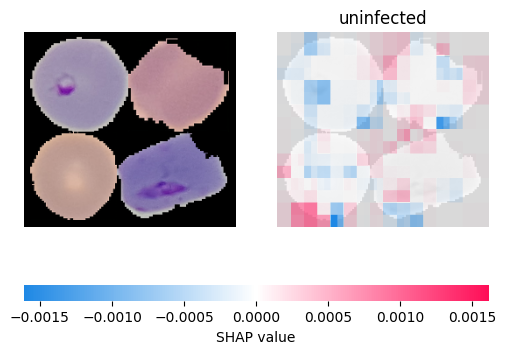

In [88]:
# 可视化
shap.image_plot(shap_values=shap_values.values,
                pixel_values=shap_values.data,
                labels=shap_values.output_names)

## 指定多个预测类别

In [89]:
# 5 柠檬
# 12 石榴
# 15 脐橙
shap_values = explainer(input_img, max_evals=n_evals, batch_size=batch_size, outputs=[0,1])

  0%|          | 0/4998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:18, 18.11s/it]               


In [90]:
# 整理张量维度
shap_values.data = inv_transform(shap_values.data).cpu().numpy()[0] # 原图
shap_values.values = [val for val in np.moveaxis(shap_values.values[0],-1, 0)] # shap值热力图

In [91]:
# shap值热力图：每个像素，对于每个类别的shap值
shap_values.shape

(2, 224, 242, 3)

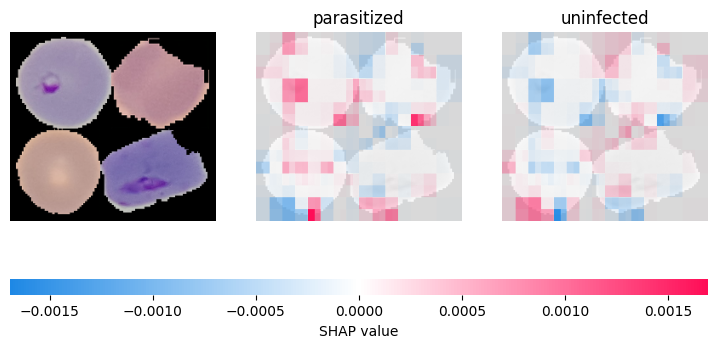

In [92]:
# 可视化
shap.image_plot(shap_values=shap_values.values,
                pixel_values=shap_values.data,
                labels=shap_values.output_names)

## 前k个预测类别

In [54]:
topk = 2

In [55]:
shap_values = explainer(input_img, max_evals=n_evals, batch_size=batch_size, outputs=shap.Explanation.argsort.flip[:topk])

  0%|          | 0/4998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:16, 16.05s/it]               


In [56]:
# shap值热力图：每个像素，对于每个类别的shap值
shap_values.shape

(1, 235, 224, 3, 2)

In [57]:
# 整理张量维度
shap_values.data = inv_transform(shap_values.data).cpu().numpy()[0] # 原图
shap_values.values = [val for val in np.moveaxis(shap_values.values[0],-1, 0)] # 各个类别的shap值热力图

In [58]:
# 各个类别的shap值热力图
len(shap_values.values)

2

In [59]:
# 第一个类别，shap值热力图
shap_values.values[0].shape

(235, 224, 3)

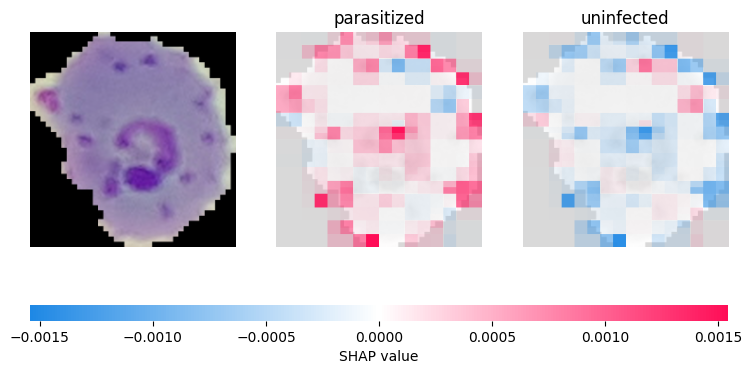

In [60]:
# 可视化
shap.image_plot(shap_values=shap_values.values,
                pixel_values=shap_values.data,
                labels=shap_values.output_names
                )